In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

from utils.networks import *
from utils.trainer import *
from utils.formulations import *

# Data generating process

Text(0, 0.5, '$y$')

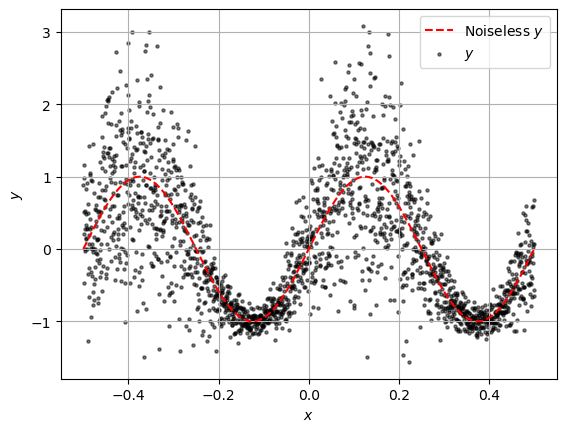

In [2]:
np.random.seed(0)

N = 2000

# x = np.sort(np.random.uniform(low = -4, high = 4, size = (N, 1)), axis = 0)
# y_true = x**3
# y = y_true + np.random.normal(loc = 0, scale = 2*np.abs(x) + np.exp(x), size = (N, y_true.shape[1]))
x = np.linspace(-0.5, 0.5, N).reshape(-1,1)
y_true = np.sin(4*np.pi*x)
y = y_true + np.random.normal(loc = 0, scale = (0.5 + 0.4*np.sin(4*np.pi*x)), size = (N, y_true.shape[1]))

fig, ax = plt.subplots()
ax.plot(x, y_true, color = 'red', linestyle = 'dashed', label = 'Noiseless $y$')
ax.scatter(x, y, s = 5, alpha = 0.5, color = 'black', label = '$y$')
ax.legend()
ax.grid()
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

# PI estimation by the sum-$k$ formulation

----------Training using: cpu----------
Epoch [50/1000], Training Loss: 0.2354, Val Loss: 0.2401
Epoch [100/1000], Training Loss: 0.1985, Val Loss: 0.2261
Epoch [150/1000], Training Loss: 0.1924, Val Loss: 0.2256
Epoch [200/1000], Training Loss: 0.1893, Val Loss: 0.2062
Epoch [250/1000], Training Loss: 0.1945, Val Loss: 0.2260
Epoch [300/1000], Training Loss: 0.1909, Val Loss: 0.2223
Epoch [350/1000], Training Loss: 0.2040, Val Loss: 0.2080
Epoch [400/1000], Training Loss: 0.1892, Val Loss: 0.2136
Epoch [450/1000], Training Loss: 0.1988, Val Loss: 0.2109
Epoch [500/1000], Training Loss: 0.1899, Val Loss: 0.2140
Epoch [550/1000], Training Loss: 0.1825, Val Loss: 0.2184
Epoch [600/1000], Training Loss: 0.1879, Val Loss: 0.2199
Epoch [650/1000], Training Loss: 0.1917, Val Loss: 0.2237
Early stopping occurs within 664 Epochs.
The best model occurs in 464 Epoch with the training Loss: 0.1928, the val. Loss: 0.1907.


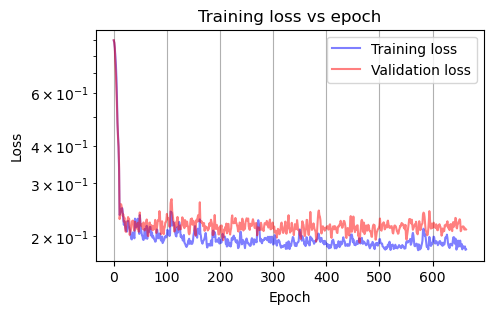

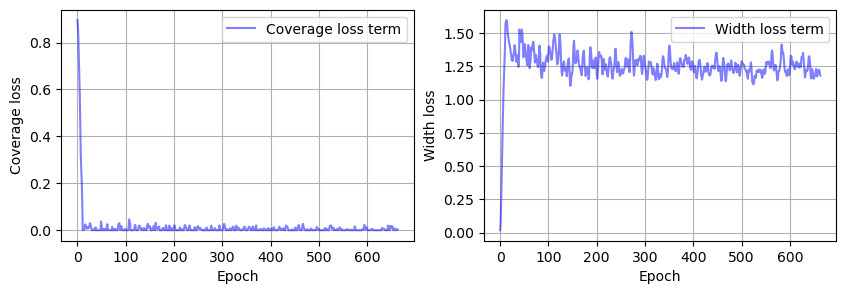

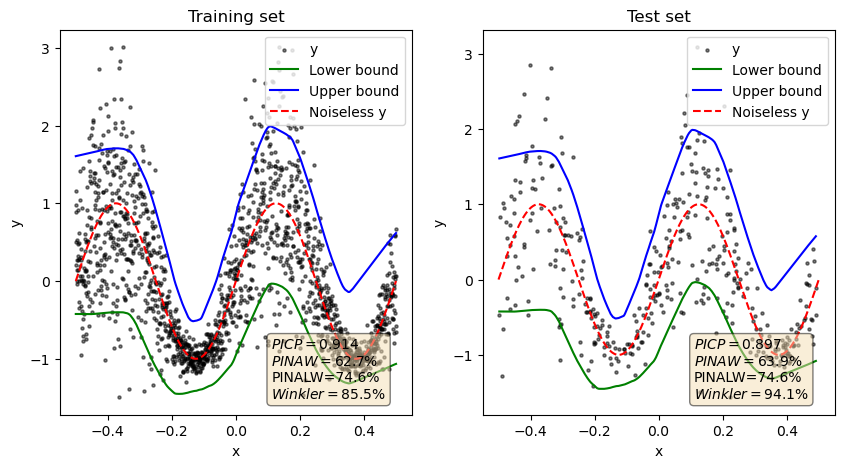

In [3]:
X_input = x
y_input = y.ravel()
# Set the desired probabilit to 1 - delta = 0.9
delta = 0.1
# Set the hyperparameter of the sum-k formulation
k_sumk = 0.3
gamma_sumk = 0.15
lambda_sumk = 0.9

# Fix random seeed for model initialization
torch.manual_seed(21)
# Set a model architecture
model = CustomNet(input_size = X_input.shape[1], hidden_size = 100, output_size = 2)
# Set an optimizer and learning rate
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
# Define the loss function
criterion = sumk_objective(delta_ = delta, gamma_ = gamma_sumk, percentlargest_ = k_sumk, lambda_ = lambda_sumk
                         , soften_ = 50, smoothfunction = 'tanh', returnseparatedloss = True)
# Define the trainer to set optimization hyperparameters in training process
train = trainer(num_epochs = 1000, batch_size = 500, patience = 200, epoch_showloss = 50)
# Split the data into train and validation set
X_train, y_train, X_val, y_val = train.train_test_split(X_input, y_input, val_ratio = 0.2)
# Training the model
train_loss_list, val_loss_list, model, PICP_train, PINAW_train = train.training(X_train, y_train, X_val, y_val, criterion, optimizer, model)

# Monitor the loss
train.plotloss(train_loss_list, val_loss_list, PICP_plot = PICP_train, PINAW_plot = PINAW_train)
# Plot the PI result
train.plotresult(model, X_input, y_input, X_train, y_train, X_val, y_val, y_true)

# Sort X, y after randomly splitting
X_train_sorted, y_train_sorted = train.sort_x_toplot(X_train, y_train)
X_val_sorted, y_val_sorted = train.sort_x_toplot(X_val, y_val)
# Provide PI for train set
outputs_train = train.predict(X_train_sorted, model, ymean = torch.mean(y_train), ystd = torch.std(y_train))
# Provide PI for validation set
outputs_val = train.predict(X_val_sorted, model, ymean = torch.mean(y_train), ystd = torch.std(y_train))

# Illustrate the PI result

Text(0, 0.5, '$y$')

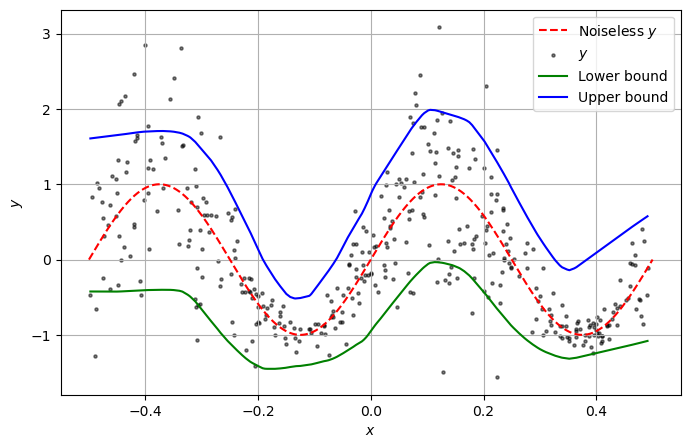

In [4]:
lower_bound = outputs_val[:,0]
upper_bound = outputs_val[:,1]

fig, ax = plt.subplots(figsize = (8, 5))
ax.plot(x, y_true, color = 'red', linestyle = 'dashed', label = 'Noiseless $y$')
ax.scatter(X_val, y_val, s = 5, alpha = 0.5, color = 'black', label = '$y$')

ax.plot(X_val_sorted, lower_bound, color = 'green', label = 'Lower bound')
ax.plot(X_val_sorted, upper_bound, color = 'blue', label = 'Upper bound')

ax.legend()
ax.grid()
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')